In [1]:
from pybird import config
config.set_jax_enabled(True) # Enable JAX by setting the config Class
import jax.numpy as jnp
from pybird.correlator import Correlator


import numpy as np
import scipy
from classy import Class
from scipy.interpolate import interp1d
import utils 
import h5py
import matplotlib.pyplot as plt 
import os 
import jax
import time
import jax.numpy as jnp

using jax


## In this notebook we outline the knots decomposition process and validate this

### Lets begin with loading in a bank of pre-made Pks on a kk grid

* Here we also define a fiducial covariance which will be used in the validation stage

In [2]:
k_arr = np.array([0.001 , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
    0.02  , 0.0225, 0.025 , 0.0275, 0.03  , 0.035 , 0.04  , 0.045 ,
    0.05  , 0.055 , 0.06  , 0.065 , 0.07  , 0.075 , 0.08  , 0.085 ,
    0.09  , 0.095 , 0.1   , 0.105 , 0.11  , 0.115 , 0.12  , 0.125 ,
    0.13  , 0.135 , 0.14  , 0.145 , 0.15  , 0.155 , 0.16  , 0.165 ,
    0.17  , 0.175 , 0.18  , 0.185 , 0.19  , 0.195 , 0.2   , 0.205 ,
    0.21  , 0.215 , 0.22  , 0.225 , 0.23  , 0.235 , 0.24  , 0.245 ,
    0.25  , 0.255 , 0.26  , 0.265 , 0.27  , 0.275 , 0.28  , 0.285 ,
    0.29  , 0.295 , 0.3   , 0.31  , 0.32  , 0.33  , 0.34  , 0.35  ,
    0.36  , 0.37  , 0.38  , 0.39  , 0.4])

nbank = 50

In [3]:
outdir = os.path.join('/cluster/work/refregier/alexree/frequentist_framework/pybird_emu', 'data', 'eftboss', 'out')
with open(os.path.join(outdir, 'fit_boss_onesky_pk_wc_cmass_ngc_l0.dat')) as f: data_file = f.read()
eft_params_str = data_file.split(', \n')[1].replace("# ", "")
eft_params = {key: float(value) for key, value in (pair.split(': ') for pair in eft_params_str.split(', '))}
print (eft_params)

{'b1': 1.9536, 'c2': 0.5865, 'c4': 0.0, 'b3': -0.3595, 'cct': 0.1821, 'cr1': -0.8417, 'cr2': -0.808, 'ce0': 1.4954, 'ce1': 0.0, 'ce2': -1.6292, 'b2': 0.4147, 'b4': 0.4147}


In [4]:
def load_pk(file_path, nbank, kk):
    with h5py.File(file_path + 'total_data.h5', 'r') as f:
        lhc_pk_lin = f["pk_lin"][:nbank]
        param_array = f["params"][:nbank]

    lhc_pk_lin = np.array(lhc_pk_lin)

    param_order = ['omega_cdm', 'omega_b', 'h', 'Omega_k', 'n_s', 'N_ur', 'm_ncdm', 'w0_fld', 'z']

    lhc_cosmo_dict = {
        param_order[i]: param_array[:, i] for i in range(param_array.shape[1])
    }

    return lhc_cosmo_dict, lhc_pk_lin

k_l, k_r =  1e-4, 1.0 #In Mpc/h
kk = np.logspace(-5, 1, 1000)
mask = (kk < k_l) | (kk > k_r)
# mask = np.where((kk>k_l) & (kk<k_r))
kk_ = kk[mask]
#Get covariance matrix at reference cosmology 
z=0.5
M = Class()
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 30, 'z_max_pk': z})
M.compute()

D1, f1 = M.scale_independent_growth_factor(z), M.scale_independent_growth_factor_f(z)
Omega0_m = M.Omega0_m()
pk_lin = np.array([M.pk_lin(k*M.h(), z)*M.h()**3 for k in kk]) # k in Mpc/h, pk in (Mpc/h)^3
ipk_h = interp1d(kk, pk_lin, kind='cubic')

Vs = 1.e11      # ideal volume (in [Mpc/h]^3), > 3 x better than DESI / Euclid (BOSS ~ 3e9, DESI ~ 3e10)
nbar = 5e-3     # ideal nbar (for b1~2) (in [Mpc/h]^3), > 3 x better than DESI / Euclid

# Vs = 1.e11      # ideal volume (in [Mpc/h]^3), > 3 x better than DESI / Euclid (BOSS ~ 3e9, DESI ~ 3e10)
# nbar = 6e-3     # ideal nbar (for b1~2) (in [Mpc/h]^3), > 12 x better than DESI / Euclid
cov = utils.get_cov(k_arr, ipk_h, eft_params["b1"], f1, mult=3, nbar=nbar, Vs=Vs)
cov_inv = np.linalg.inv(cov)
err_0 = np.sqrt(np.diag(cov))

lhc_cosmo_dict, lhc_pk_lin = load_pk('/cluster/work/refregier/alexree/frequentist_framework/FreqCosmo/lhc_bank_z0p5to2p5/', nbank, kk)

In [5]:
lhc_pk_lin.shape

(50, 1000)

In [6]:
M_test = Class()
cosmo = {key: lhc_cosmo_dict[key][7] for key in lhc_cosmo_dict.keys() if key not in ["z"]}
M_test.set({"output":"mPk", 
                        "N_ncdm": 1,
                        "T_ncdm": 0.71611,
                        "Omega_Lambda": 0,
                       'z_max_pk': 0.5})
    
M_test.set(cosmo)
M_test.set({'output': 'mPk', 'P_k_max_h/Mpc': 30, 'z_max_pk': z})
M_test.compute()

pk_lin = np.array([M_test.pk_lin(k*M_test.h(), z)*M_test.h()**3 for k in kk]) # k in Mpc/h, pk in (Mpc/h)^3


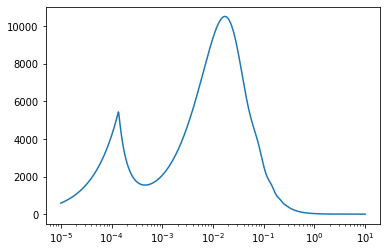

In [7]:
fig, ax = plt.subplots()
ax.set_xscale("log")

ax.plot(kk, pk_lin)

In [8]:
err_0

array([5.99708372e+03, 4.18508429e+03, 3.58115884e+03, 3.07548073e+03,
       2.64616593e+03, 2.27864528e+03, 1.96198815e+03, 1.68815678e+03,
       1.45134261e+03, 1.24696824e+03, 1.07141971e+03, 9.21286967e+02,
       5.61309812e+02, 4.21548383e+02, 3.24270923e+02, 2.57563757e+02,
       2.11681767e+02, 1.79310137e+02, 1.55108485e+02, 1.35472269e+02,
       1.18283349e+02, 1.02558906e+02, 8.81032166e+01, 7.51382913e+01,
       6.39590004e+01, 5.47440147e+01, 4.74599084e+01, 4.18808847e+01,
       3.76641895e+01, 3.44169019e+01, 3.17707694e+01, 2.94158878e+01,
       2.71461197e+01, 2.48656520e+01, 2.25746090e+01, 2.03417942e+01,
       1.82607684e+01, 1.64118074e+01, 1.48422898e+01, 1.35583920e+01,
       1.25308672e+01, 1.17067777e+01, 1.10228019e+01, 1.04188338e+01,
       9.84515486e+00, 9.26771381e+00, 8.67456283e+00, 8.07383659e+00,
       7.48567646e+00, 6.93220725e+00, 6.43053404e+00, 5.99019604e+00,
       5.61285138e+00, 5.29315576e+00, 5.02092964e+00, 4.78224614e+00,
      

7


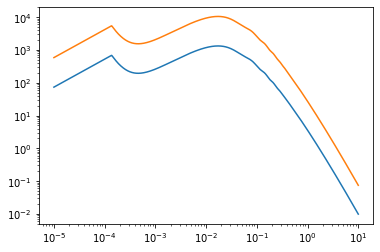

In [9]:
fig,ax =plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
for i in range(7,8): 
    print(i)
    ax.plot(kk, lhc_pk_lin[i])

ax.plot(kk, pk_lin)

### Need to finally get the required pieces for the knots decomposition

In [10]:
def get_logslope(x, f, side='left'):
    if side == 'left': 
        n = (jnp.log(f[1]) - jnp.log(f[0])) / (jnp.log(x[1]) - jnp.log(x[0]))
        A = f[0] / x[0]**n
    elif side == 'right':
        n = (jnp.log(f[-1]) - jnp.log(f[-2])) / (jnp.log(x[-1]) - jnp.log(x[-2]))
        A = f[-1] / x[-1]**n
    return A, n 

def return_info(lhc_pk_lin_i, kk, kk_): 
    pk_i = 1.*lhc_pk_lin_i
    pk_max = jnp.max(pk_i)
    pk = jnp.array(1.*pk_i / pk_max) # normalizing
    ilogpk = utils.InterpolatedUnivariateSpline_jax(jnp.log(kk), jnp.log(pk), k=3, endpoints='natural')
    pkk_ = jnp.exp(ilogpk(jnp.log(kk_)))

    A_l, n_l = get_logslope(kk_, pkk_, side='left')
    A_r, n_r = get_logslope(kk_, pkk_, side='right')

    pk_r = A_r * k_r**n_r
    dpk_r = A_r * n_r * k_r**(n_r-1.)
    dlogpk_r = (k_r/pk_r * dpk_r)

    return {'pk':pk, 'dlogpk_r': jnp.array(dlogpk_r), 'pk_max':pk_max}

return_info_jit = jax.jit(return_info)

start = time.time()

#use vmap to get the info for each pk in the bank
pk_info_dict_list = jax.vmap(return_info_jit, in_axes=(0, None, None))(lhc_pk_lin, kk, kk_)
print(f"Time taken to get pk_info_dict_list: {time.time()-start}")

Time taken to get pk_info_dict_list: 0.42856407165527344


### Now lets consider our starting point

* This has proven to faithfully reproduce the pybird predictions at one loop already to good accuracy

In [11]:
nknots = 75
k_mid = 0.05
n_low = 15
n_high = nknots - n_low
knots_low = np.geomspace(k_l, k_mid, n_low)
knots_high = np.geomspace(k_mid+0.001, k_r, n_high)
knots = np.concatenate((knots_low,knots_high))

### Set up the PyBird testing

* Need to make everything a JAX array to make this work

In [12]:
knots = jnp.array(knots)
kk = jnp.array(kk)

In [13]:
N = Correlator()

N.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.4,
       'fftaccboost': 2, # boosting the FFTLog precision (slower, but ~0.1% more precise -> let's emulate this)
       'with_resum': False, 'with_exact_time': True,
       'km': 1., 'kr': 1., 'nd': 3e-4,
       'eft_basis': 'eftoflss', 'with_stoch': True})
N.compute({'kk': kk, 'pk_lin': jnp.array(lhc_pk_lin[0]), 'D': D1, 'f': f1, 'z': z, 'Omega0_m': Omega0_m},
          do_core=True, do_survey_specific=True)
bpk_benchmark = N.get(eft_params)


In [14]:
from pybird import config
config.set_jax_enabled(True) # Enable JAX by setting the config Class
import jax.numpy as jnp
from pybird.correlator import Correlator

In [15]:
from pybird import config
config.set_jax_enabled(True) # Enable JAX by setting the config Class

In [16]:
Omega0_m

0.3124279835390946

In [17]:
indices = jnp.where((kk>k_l) & (kk<k_r))

In [18]:
N = Correlator()
N.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.4,
       'fftaccboost': 2, # boosting the FFTLog precision (slower, but ~0.1% more precise -> let's emulate this)
       'with_resum': False, 'with_exact_time': True,
       'km': 1., 'kr': 1., 'nd': 3e-4,
       'eft_basis': 'eftoflss', 'with_stoch': True})

N_rec = Correlator()
N_rec.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.4,
       'fftaccboost': 2, # boosting the FFTLog precision (slower, but ~0.1% more precise -> let's emulate this)
       'with_resum': False, 'with_exact_time': True,
       'km': 1., 'kr': 1., 'nd': 3e-4,
       'eft_basis': 'eftoflss', 'with_stoch': True})

In [19]:
def get_pybird_chi2(knots, kk, cov_inv, pk_input, dlogpk_r, pk_max, return_spectra=False):
    # Construct the spline
    ilogpk = utils.InterpolatedUnivariateSpline_jax(jnp.log(kk), \
    jnp.log(pk_input),endpoints='natural')
    logpk = ilogpk(jnp.log(knots))

    spline = utils.PiecewiseSpline_jax(knots, logpk, dlogpk_r)

    prediction_pklin = jnp.exp(spline(jnp.log(kk)))
    
    einsum_str = 'b,lbx->lx'
    
    
    
    N.compute({'kk': kk[indices], 'pk_lin': jnp.array(pk_input[indices])*pk_max, 'D': D1, 'f': f1, 'z': z, 'Omega0_m': Omega0_m},
            do_core=True, do_survey_specific=True)
    
    bpk_truth = N.get(eft_params)

    N_rec.compute({'kk': kk[indices], 'pk_lin': jnp.array(prediction_pklin[indices])*pk_max, 'D': D1, 'f': f1, 'z': z, 'Omega0_m': Omega0_m},
            do_core=True, do_survey_specific=True)
    
    N_rec.get(eft_params)

    N.bird.Ploopl = N_rec.bird.Ploopl
    N.bird.setreducePslb(N.bias)
    
    bpk_reconstructed = N.bird.fullPs

    difference = bpk_truth.flatten() - bpk_reconstructed.flatten()
    chi2 = jnp.dot(difference, jnp.dot(cov_inv, difference))
    
    if return_spectra: 
        return chi2, bpk_truth, bpk_reconstructed, prediction_pklin
    return chi2


In [20]:
get_pybird_chi2_vmap = jax.vmap(get_pybird_chi2, in_axes=(None, None, None, 0, 0, 0))

In [21]:
get_pybird_chi2_vmap(knots, kk, cov_inv, pk_info_dict_list["pk"][0:5], pk_info_dict_list["dlogpk_r"][0:5], \
        pk_info_dict_list["pk_max"][0:5])

Array([4.9698967e-03, 2.8519660e-01, 4.6763282e+00, 1.2881975e-03,
       9.7744188e+00], dtype=float32)

In [22]:
chi2, bpk_truth, bpk_reconstructed, prediction_pklin = get_pybird_chi2(knots, kk, cov_inv, \
pk_info_dict_list["pk"][4], pk_info_dict_list["dlogpk_r"][4], \
pk_info_dict_list["pk_max"][4], return_spectra=True)

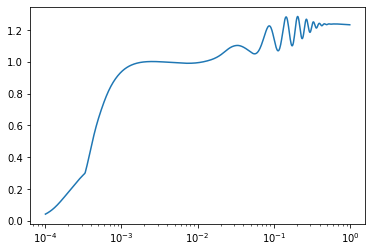

In [23]:
plt.plot(kk[~mask], pk_info_dict_list["pk"][0][~mask]/prediction_pklin[~mask])
plt.xscale("log")

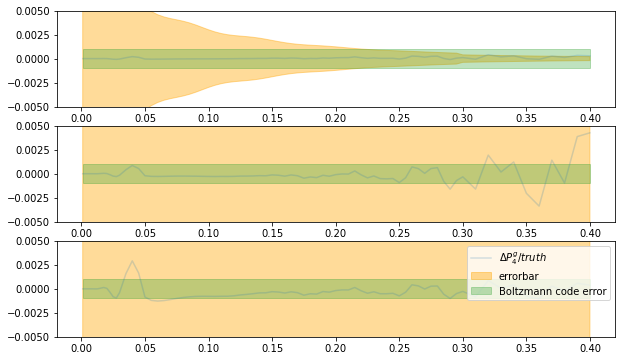

In [24]:
fig, ax = plt.subplots(3,1,figsize =(10,6))

# truth = bpk_benchmark
truth = bpk_truth
reconstructed = bpk_reconstructed
for i, ell in enumerate([0, 2, 4]):
    ax[i].plot(k_arr, (truth[i]-reconstructed[i])/truth[i], 'C0', alpha=0.2, label=fr'$\Delta P^g_{ell}/truth$')
    ax[i].fill_between(k_arr, -err_0[i*77:(i+1)*77]/truth[i], err_0[i*77:(i+1)*77]/truth[i], color='orange', alpha=.4, label='errorbar')
    ax[i].fill_between(k_arr, -1e-3*np.ones_like(k_arr), 1e-3*np.ones_like(k_arr), color='C2', alpha=.3, label='Boltzmann code error')
    ax[i].set_ylim([-0.005,0.005])

plt.legend()

In [25]:
np.sqrt(chi2/(77*3))

0.20569469

### Now finally lets JIT this function and do some optimization

In [26]:
get_pybird_chi2_jit = jax.jit(get_pybird_chi2)

In [27]:
%%timeit

get_pybird_chi2_jit(knots, kk, cov_inv, \
            pk_info_dict_list["pk"][0], pk_info_dict_list["dlogpk_r"][0], \
            pk_info_dict_list["pk_max"][0])

46.3 ms ± 5.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
get_pybird_chi2_jit_vmap = jax.vmap(get_pybird_chi2_jit, in_axes=(None, None, None, 0,0,0))

In [29]:
pk_info_dict_list["pk"].shape 

(50, 1000)

In [30]:
# starting with Jitting need to make a wrapper function as cant pass PyBird classes around
def get_chi2_multiple(internal_knots):
    
    knots = jnp.concatenate((jnp.array([k_l]), internal_knots, jnp.array([k_r])))
    chi2=0
    for i in range(pk_info_dict_list["pk"].shape[0]):
        chi2 += get_pybird_chi2_jit(knots, kk, cov_inv, \
            pk_info_dict_list["pk"][i], pk_info_dict_list["dlogpk_r"][i], \
            pk_info_dict_list["pk_max"][i])
            
    return chi2/pk_info_dict_list["pk"].shape[1]/77*3

In [31]:
start = time.time()
get_chi2_multiple(knots[1:-1])
print("time for 50:", time.time()-start)

time for 50: 2.158705949783325


### Now finally for some optimization 
* I did try with VMAP instead of the loop but the memory overhead was very high

In [32]:
import optax

In [37]:
# Gradient of the function with respect to its parameters
gradient_function = jax.grad(get_chi2_multiple)

# Initial parameters (internal knots), assuming a shape that matches your requirements
internal_knots_init = knots[1:-1]  # Replace `initial_guesses` with your initial values

# Set up the optimizer (for example, Stochastic Gradient Descent with a certain learning rate)
optimizer = optax.sgd(learning_rate=0.01)
opt_state = optimizer.init(internal_knots_init)

In [40]:
gradient_function(knots[1:-1])

Array([ 2.5305260e-02,  2.2516043e-01,  1.4061044e+00,  1.8777096e-01,
       -4.3570915e-01,  3.0036805e-02,  2.9808037e-02, -3.2184608e-02,
       -1.3483779e-01,  8.1080186e-01, -1.2827334e+01,  6.9703415e+01,
       -9.3598267e+01,  5.1123425e+01,  1.5701803e+01,  6.1853069e-01,
       -5.5844695e-03,  1.3377378e-02,  1.5315781e-02,  2.1503814e-02,
        1.1103454e-02, -3.7135170e-03, -6.3832109e-03, -9.4129797e-03,
       -3.4851961e-02, -3.4088336e-02,  5.5439002e-03, -1.7734112e-02,
        4.1008268e-02,  3.8146485e-02,  1.2258885e-02,  2.8928913e-02,
       -2.2445358e-02, -3.4345537e-02, -5.0029512e-02, -2.9949246e-02,
        5.6800742e-02,  3.8433995e-02, -3.5546180e-03, -3.6580689e-02,
       -1.1382258e-02, -6.0131466e-03,  3.4759067e-02, -8.2320325e-02,
       -1.2590146e-01,  2.3639932e-01, -3.4558412e-02, -1.4307939e-01,
       -7.6826066e-01,  2.0846918e-01, -1.6367011e+00,  8.6218989e-01,
       -7.3168522e-01,  3.1436124e-01, -8.4151620e-01, -2.4251333e-01,
      

In [41]:
# Optimization loop
from jax import config
config.update("jax_debug_nans", True)

num_steps = 10  # Number of optimization steps
for step in range(num_steps):
    grads = gradient_function(internal_knots_init)
    updates, opt_state = optimizer.update(grads, opt_state)
    internal_knots_init = optax.apply_updates(internal_knots_init, updates)

    if step % 2 == 0:  # Print information every 10 steps
        loss = get_chi2_multiple(internal_knots_init)
        print(f"Step {step}, Loss: {loss}")

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in jit(convert_element_type). Because jax_config.debug_nans.value and/or config.jax_debug_infs is set, the de-optimized function (i.e., the function as if the `jit` decorator were removed) was called in an attempt to get a more precise error message. However, the de-optimized function did not produce invalid values during its execution. This behavior can result from `jit` optimizations causing the invalid value to be produced. It may also arise from having nan/inf constants as outputs, like `jax.jit(lambda ...: jax.numpy.nan)(...)`. 

It may be possible to avoid the invalid value by removing the `jit` decorator, at the cost of losing optimizations. 

If you see this error, consider opening a bug report at https://github.com/google/jax.